![konya](images/ktun.png)
<h4><center>T.C.<br>KONYA TEKNİK ÜNİVERSİTESİ<br>LİSANSÜSTÜ EĞİTİM ENSTİTÜSÜ</center><h4>

<strong><center>Dental X-ray Image Analysis</center></strong>
<strong><center>Cephalometric Keypoints Detection using CNN Run</center></strong><br>

### Automated Detection and Analysis for Diagnosis in Cephalometric X-ray Image Using Convolutional Neural Network

## Display of the points got from test images using the trained Convolutional Neural Network

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform, img_as_float
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models # add models to the list
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.utils import make_grid
import time
import random
import csv

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [61]:
# Take a look at one of the image samples and labels

#NOTE: THE IMAGE FOLDERS HAS BEEN MODIFIED AND SEPERATED INTO TRAIN AND TEST FOLDERS SETS
SAMPLE_PATH = "data/RawImage/Test1Data/155.bmp"
TXT_PATH = "logs/test1/ensemble/Ensemble/predictions/1.csv"
TXT_REAL_PATH = "data/AnnotationsByMD/400_senior/155.txt"


# import sample image
img = io.imread(SAMPLE_PATH, as_gray=True)
img

array([[0.13333333, 0.13333333, 0.12941176, ..., 0.89411765, 0.90588235,
        0.        ],
       [0.13333333, 0.13333333, 0.12941176, ..., 0.89411765, 0.90588235,
        0.        ],
       [0.13333333, 0.13333333, 0.12941176, ..., 0.89411765, 0.90588235,
        0.        ],
       ...,
       [0.89803922, 0.89803922, 0.89803922, ..., 0.89411765, 0.92156863,
        0.        ],
       [0.89803922, 0.89803922, 0.89803922, ..., 0.90980392, 0.88627451,
        0.01176471],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00784314]])

In [62]:
TXT_PATH

'logs/test1/ensemble/Ensemble/predictions/1.csv'

In [63]:
img.shape

(2400, 1935)

In [64]:
# with open(TXT_PATH) as csvfile:
#      print("\n".join([x.split(",")[1] for x in file1.read().split("\n")]))
def merge(list1, list2): 
      
    merged_list = [tuple([int(float(list1[i])),int(float(list2[i]))]) for i in range(0, len(list1))] 
    return merged_list 

In [65]:
def extract_cordinate_from_cvs(path):
    with open(path) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        print(readCSV)
        x_cordinates = []
        y_cordinates = []
        index = 0
        for row in readCSV:
#             print(row)
            if(index == 1):
                y_cords = row[21:40]
                x_cords = row[40:]
               
                print(merge(x_cords, y_cords))
                cordinates = merge(x_cords, y_cords)
                break
            index +=1
    return cordinates

In [66]:
extract_cordinate_from_cvs(TXT_PATH)

[(854, 1050), (1429, 1050), (1300, 1294), (627, 1219), (1368, 1575), (1308, 1894), (1285, 2006), (1240, 2062), (1270, 2044), (733, 1753), (1368, 1762), (1383, 1762), (1527, 1706), (1474, 1866), (1459, 1575), (1368, 2091), (960, 1453), (1406, 1519), (665, 1331)]


[(854, 1050),
 (1429, 1050),
 (1300, 1294),
 (627, 1219),
 (1368, 1575),
 (1308, 1894),
 (1285, 2006),
 (1240, 2062),
 (1270, 2044),
 (733, 1753),
 (1368, 1762),
 (1383, 1762),
 (1527, 1706),
 (1474, 1866),
 (1459, 1575),
 (1368, 2091),
 (960, 1453),
 (1406, 1519),
 (665, 1331)]

In [67]:
def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:19]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

In [68]:
extract_labels_from_txt(TXT_REAL_PATH)

[(737, 1034),
 (1341, 936),
 (1189, 1189),
 (614, 1156),
 (1340, 1470),
 (1280, 1791),
 (1271, 1928),
 (1223, 1976),
 (1255, 1963),
 (686, 1668),
 (1316, 1631),
 (1365, 1655),
 (1477, 1543),
 (1447, 1743),
 (1441, 1427),
 (1326, 1976),
 (913, 1379),
 (1325, 1387),
 (664, 1290)]

In [69]:
ORIG_IMAGE_X = 1935
ORIG_IMAGE_Y = 2400
PIXELS_PER_MM = 10
N_LANDMARKS = 19

# (2400, 1935)

In [73]:
def print_image(img,coords_raw):
    plt.rcParams["figure.figsize"] = [32,18]
    plt.style.use(['dark_background'])
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 1, 1)
    ax1.imshow(img, cmap="gray")
    # also plot resized image for later 
    orig_y, orig_x = img.shape[:2]
    SCALE = 9.375

    # for rescale, use same target for both x&y axis
    rescaled_img = transform.resize(img,(orig_y/9.375,orig_y/9.375))
    ax2.imshow(rescaled_img, cmap="gray")

    for c in coords_raw:
        # add patches to original image
        # could also just plt.scatter() but less control then
        ax1.add_patch(plt.Circle(c, 5, color='g')) 
        # and rescaled marks to resized images
        x,y = c
        x = int(x*(orig_y*1.0/orig_x)/SCALE)
        y = int(y/SCALE)
        ax2.add_patch(plt.Circle((x,y), 1, color='g')) 

    plt.show()

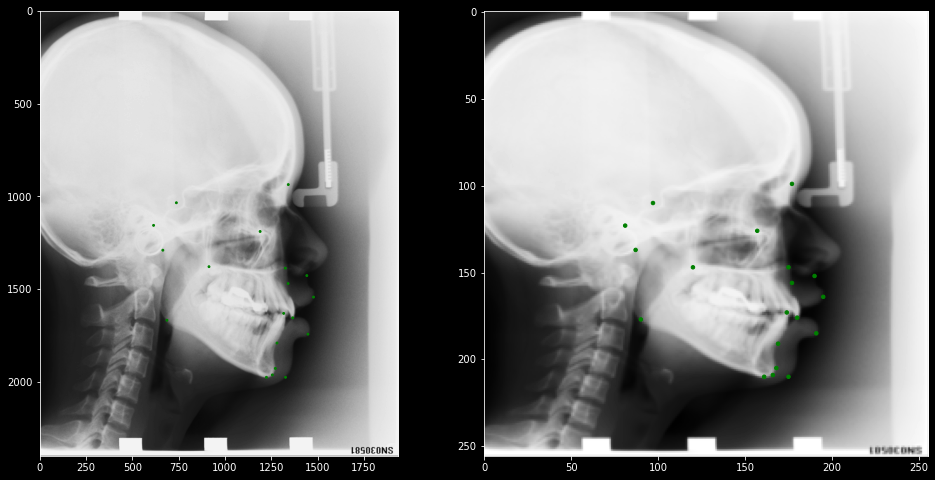

In [74]:
print_image(img, extract_labels_from_txt(TXT_REAL_PATH))

[(854, 1050), (1429, 1050), (1300, 1294), (627, 1219), (1368, 1575), (1308, 1894), (1285, 2006), (1240, 2062), (1270, 2044), (733, 1753), (1368, 1762), (1383, 1762), (1527, 1706), (1474, 1866), (1459, 1575), (1368, 2091), (960, 1453), (1406, 1519), (665, 1331)]


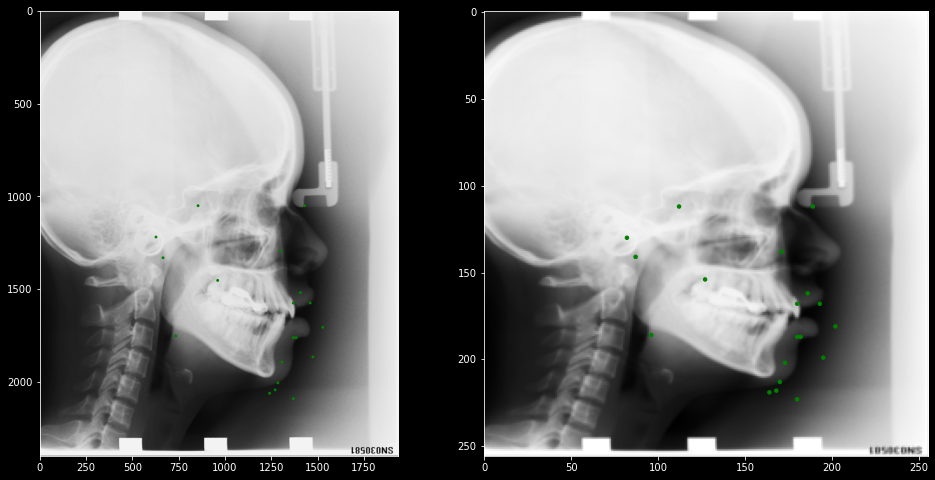

In [75]:
print_image(img, extract_cordinate_from_cvs(TXT_PATH))